In [1]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
 
gpu_options = tf.GPUOptions(allow_growth=True)
config = tf.ConfigProto(gpu_options=gpu_options)
sess = tf.Session(config=config) 
set_session(sess)

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


In [2]:
import keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# PCA, NMF

In [5]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 9s 1us/step


In [6]:
X_train.shape

(60000, 28, 28)

In [7]:
X_train_flattened = X_train.reshape(60000, -1)

In [8]:
X_train_flattened.shape

(60000, 784)

---

http://setosa.io/ev/principal-component-analysis/

In [9]:
from sklearn.decomposition import PCA, NMF

In [10]:
def get_mnist_PCA(n_dims, X, original_size=(60000, 28, 28)):
    pca = PCA(n_components=n_dims)
    X_pcad = pca.fit_transform(X)
    X_restored = pca.inverse_transform(X_pcad)
    return X_restored.reshape(*original_size)

In [11]:
def get_mnist_NMF(n_dims, X, original_size=(60000, 28, 28)):
    nmf = NMF(n_components=n_dims)
    X_nmfd = nmf.fit_transform(X)
    X_restored = nmf.inverse_transform(X_nmfd)
    return X_restored.reshape(*original_size)

In [12]:
%%time
X_pca_200 = get_mnist_PCA(200, X_train_flattened)
X_pca_100 = get_mnist_PCA(100, X_train_flattened)
X_pca_50  = get_mnist_PCA(50,  X_train_flattened)
X_pca_20  = get_mnist_PCA(20,  X_train_flattened)
X_pca_10  = get_mnist_PCA(10,  X_train_flattened)

CPU times: user 3min 44s, sys: 3min 8s, total: 6min 52s
Wall time: 37.8 s


In [13]:
%%time
X_nmf_50  = get_mnist_NMF(50,  X_train_flattened)
X_nmf_20  = get_mnist_NMF(20,  X_train_flattened)

CPU times: user 5min 14s, sys: 1min 7s, total: 6min 22s
Wall time: 4min 42s


## Результаты

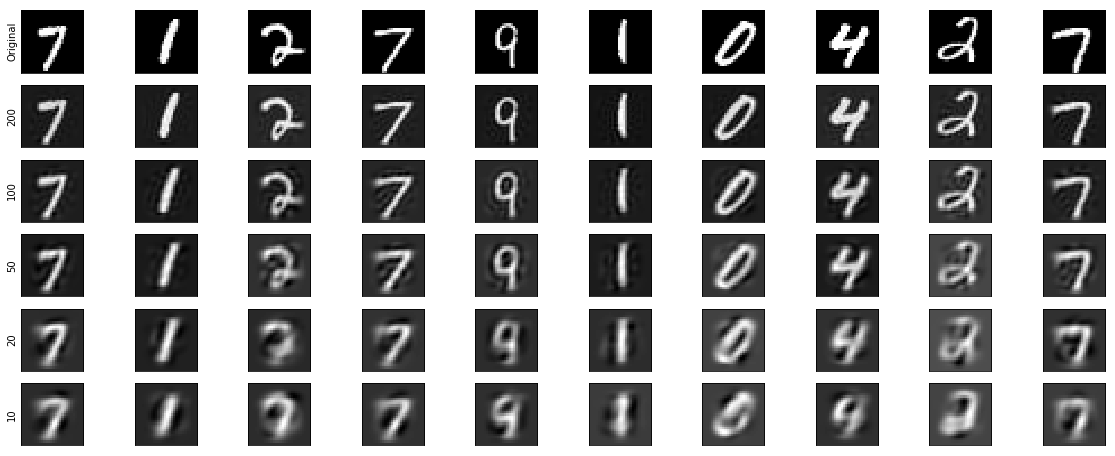

In [14]:
labels = ['200', '100', '50', '20', '10']
data = [X_pca_200, X_pca_100, X_pca_50, X_pca_20, X_pca_10]

idc = np.random.randint(0, 60000, size=10)
f, axs = plt.subplots(len(data)+1, 10, figsize=(20, 8))

for i in range(10):
    axs[0][i].imshow(X_train[idc[i], :, :], cmap='gray');
    axs[0][i].set_xticks([], [])
    axs[0][i].set_yticks([], [])
    if i == 0:
        axs[0][i].set_ylabel('Original')
    
    for j in range(len(data)):
        axs[j+1][i].imshow(data[j][idc[i], :, :], cmap='gray');
        axs[j+1][i].set_xticks([], [])
        axs[j+1][i].set_yticks([], [])
        if i == 0:
            axs[j+1][i].set_ylabel(labels[j])

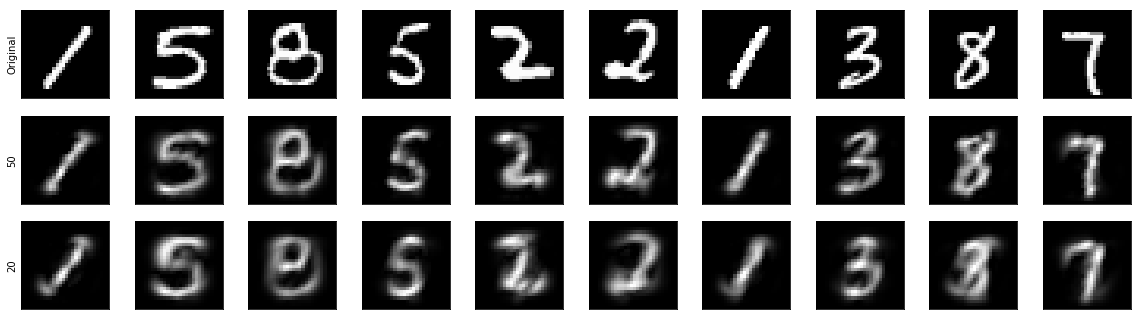

In [15]:
labels = ['50', '20']
data = [X_nmf_50, X_nmf_20]

idc = np.random.randint(0, 60000, size=10)
f, axs = plt.subplots(len(data)+1, 10, figsize=(20, 5.5))

for i in range(10):
    axs[0][i].imshow(X_train[idc[i], :, :], cmap='gray');
    axs[0][i].set_xticks([], [])
    axs[0][i].set_yticks([], [])
    if i == 0:
        axs[0][i].set_ylabel('Original')
    
    for j in range(len(data)):
        axs[j+1][i].imshow(data[j][idc[i], :, :], cmap='gray');
        axs[j+1][i].set_xticks([], [])
        axs[j+1][i].set_yticks([], [])
        if i == 0:
            axs[j+1][i].set_ylabel(labels[j])

# Подготовка данных

In [3]:
import pickle

In [4]:
with open('mnist_scaled.pickle', 'rb') as f:
    X_train, y_train, X_test, y_test = pickle.load(f)

In [5]:
X_train.shape

(60000, 32, 32, 1)

In [6]:
X_train.dtype

dtype('float64')

In [7]:
from sklearn.model_selection import train_test_split

train_X, valid_X, train_ground, valid_ground = train_test_split(X_train, X_train, 
                                                                test_size=0.2, random_state=69420)

In [8]:
train_X.shape, valid_X.shape, train_ground.shape, valid_ground.shape

((48000, 32, 32, 1),
 (12000, 32, 32, 1),
 (48000, 32, 32, 1),
 (12000, 32, 32, 1))

# Autoencoders

<img src='images/autoencoder_fc.webp'>

In [9]:
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.optimizers import RMSprop

In [10]:
from livelossplot import PlotLossesKeras

In [11]:
batch_size = 64
epochs = 50
n_channels = 1
w, h = 32, 32

In [23]:
input_img = Input(shape=(w, h, n_channels))

# encoder 
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img) 
x = MaxPooling2D((2, 2))(x) 
x = Conv2D(20, (3, 3), activation='relu', padding='same')(x) 
x = MaxPooling2D((2, 2))(x) 
x = Conv2D(24, (3, 3), activation='relu', padding='same')(x) 
x = MaxPooling2D((4, 4))(x) 

# decoder
x = Conv2D(24, (3, 3), activation='relu', padding='same')(x) 
x = UpSampling2D((4, 4))(x)
x = Conv2D(20, (3, 3), activation='relu', padding='same')(x) 
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x) 
x = UpSampling2D((2, 2))(x)
x = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x) 

In [24]:
autoencoder = Model(input_img, x)
autoencoder.compile(loss='mean_squared_error', optimizer=RMSprop(lr=0.0001))

In [25]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 16)        160       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 16, 16, 20)        2900      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 8, 8, 20)          0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 8, 8, 24)          4344      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 2, 2, 24)          0         
__________

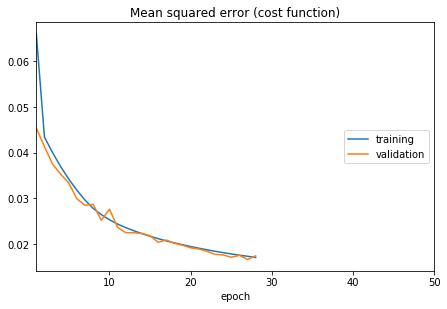

 - 4s - loss: 0.0171 - val_loss: 0.0174
Epoch 29/50


KeyboardInterrupt: 

In [26]:
history = autoencoder.fit(train_X, train_ground, 
                          batch_size=batch_size, epochs=epochs,
                          verbose=2, callbacks=[PlotLossesKeras()],
                          validation_data=(valid_X, valid_ground))

In [27]:
pred = autoencoder.predict(X_test)

In [28]:
pred.shape

(10000, 32, 32, 1)

Изображения из отложенной выборки


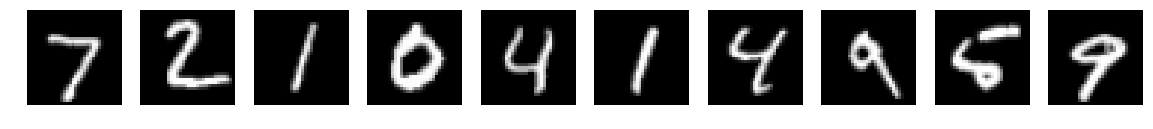

Восстановленные изображения


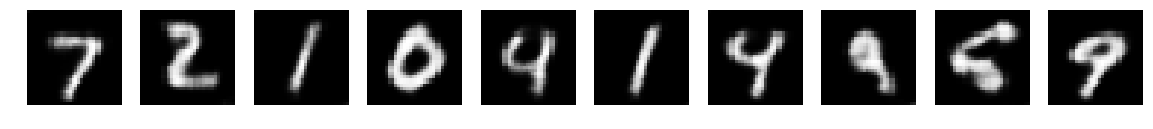

In [29]:
plt.figure(figsize=(20, 4))
print("Изображения из отложенной выборки")
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(X_test[i, ..., 0], cmap='gray')
    plt.axis('off')
plt.show()    

plt.figure(figsize=(20, 4))
print("Восстановленные изображения")
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(pred[i, ..., 0], cmap='gray')  
    plt.axis('off')
plt.show()

# Denoising Autoencoder

In [19]:
noise_factor = 0.5

x_train_noisy = train_X + noise_factor*np.random.normal(size=train_X.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)

x_valid_noisy = valid_X + noise_factor*np.random.normal(size=valid_X.shape)
x_valid_noisy = np.clip(x_valid_noisy, 0., 1.)

x_test_noisy = X_test + noise_factor * np.random.normal(size=X_test.shape)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

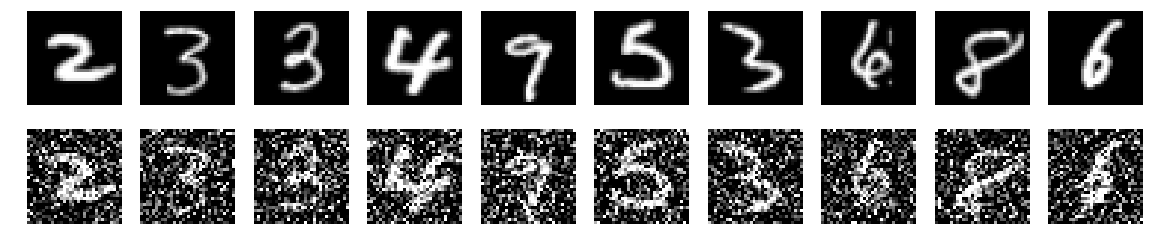

In [20]:
plt.figure(figsize=[20, 4])

idc = np.random.randint(0, len(train_X), size=10)
for i in range(10):
    plt.subplot(2,10,i+1)
    plt.imshow(np.reshape(train_X[idc[i]], (w, h)), cmap='gray')
    plt.axis('off')
    
    plt.subplot(2,10,i+11)
    plt.imshow(np.reshape(x_train_noisy[idc[i]], (w, h)), cmap='gray')
    plt.axis('off')

plt.show()

In [21]:
input_img = Input(shape=(w, h, n_channels))

# encoder 
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img) 
x = MaxPooling2D((2, 2))(x) 
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x) 
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)

# decoder
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x) 
x = UpSampling2D((2,2))(x) 
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2,2))(x) 
x = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x) 

autoencoder = Model(input_img, x)
autoencoder.compile(loss='mean_squared_error', optimizer=RMSprop(lr=0.0001))

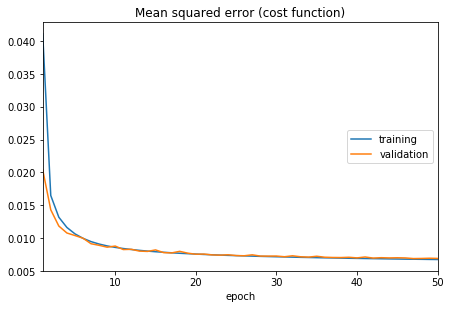

In [22]:
history = autoencoder.fit(x_train_noisy, train_X, 
                          batch_size=batch_size, epochs=epochs,
                          verbose=0, callbacks=[PlotLossesKeras()],
                          validation_data=(x_valid_noisy, valid_X))

In [36]:
pred = autoencoder.predict(x_test_noisy)

Изображения из отложенной выборки


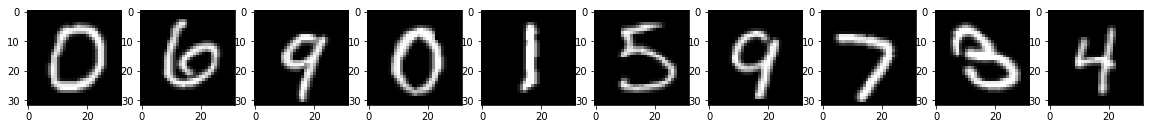

Зашумленные изображения


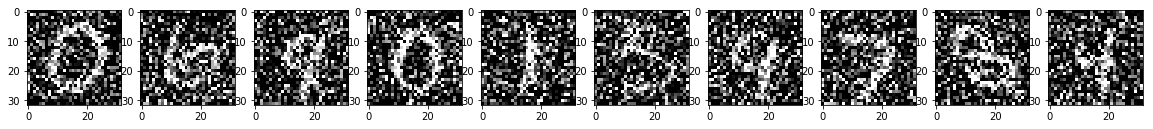

Восстановленные изображения


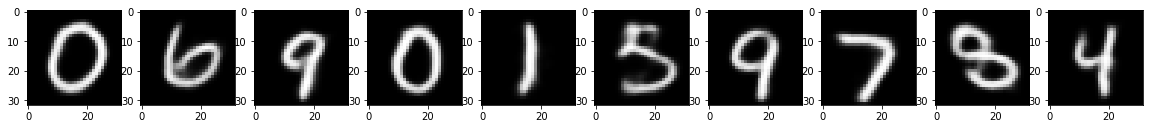

In [37]:
plt.figure(figsize=(20, 4))
print("Изображения из отложенной выборки")
for i in range(10,20,1):
    plt.subplot(2, 10, i+1)
    plt.imshow(X_test[i, ..., 0], cmap='gray')
plt.show()    

plt.figure(figsize=(20, 4))
print("Зашумленные изображения")
for i in range(10,20,1):
    plt.subplot(2, 10, i+1)
    plt.imshow(x_test_noisy[i, ..., 0], cmap='gray')
plt.show()    

plt.figure(figsize=(20, 4))
print("Восстановленные изображения")
for i in range(10,20,1):
    plt.subplot(2, 10, i+1)
    plt.imshow(pred[i, ..., 0], cmap='gray')  
plt.show()